# Homework project for the "Differential Equations" course module

1. Solve the wave equation `dt^2 u(t,x) = dx^2 u(t,x)` numerically. Use a `1+1`-dimensional domain, and use Dirichlet boundary conditions `u(t,-L) = u(t,+L) = 0`. Use the spatial domain bounds `[-1; +1]`, and use the Gaussian-like function `f(t,x) = A exp(-1/2 sin(2pi (x-t))^2 / W^2)` as initial condition. Use `L=1, A=1, W=0.2` as parameters. Evolve from `t=0` to `t=4L`, i.e. for two crossing times. Plot the result.

2. Vary the time step size `dt`. If you choose `dt` too large, the discrete system will be unstable. What is the stability limit? Why does this happen? How could you avoid this limit?

3. The energy density of a scalar wave is `epsilon(t,x) = 1/2 ((d/dt u(t,x))^2 + ((d/dx u(t,x))^2)`. Calculate the energy density as a function of space and time for your solution. Plot the result.

4. To calculate the total energy `E(t)` as a function of time, you need to integrate it over space. One way to do so is using the function below. Calculate and show the total energy `E(t)` as a function of time. How well is the energy conserved? How does this depend on the grid spacings `dx` and `dt?

In [1]:
# Integrate `epsilon` over space
function integrate(epsilon, n, dx)
    ni, nt = size(epsilon)
    # The boundary points are special; they have a weight of 1/2.
    # There are `ni` points overall, and the grid spacing is `dx = 2L/(ni-1)`.
    # Integrating the constant function `epsilon=1` thus gives exactly `2L`.
    E = epsilon[1, n] / 2
    for i in 2:ni-1
        E += epsilon[i, n]
    end
    E += epsilon[ni, n] / 2
    # Scale by the grid spacing
    E *= dx
    return E
end

integrate (generic function with 1 method)

# Problem 1

In [2]:
# Define two grid functions `t`, `x` holding the coordinates
function coords(starttime, endtime, startspatial, endspatial, ntime, nx)
    dx = (endspatial - startspatial)/nx
    dt = (endtime-starttime)/ntime
    print("dt = ", float(dt))
    print("\n dx = ", float(dx))
    t = [starttime + (n * dt) for i in 0:nx, n in 0:ntime]
    x = [startspatial + (i * dx) for i in 0:nx, n in 0:ntime]
    return t, x
end

coords (generic function with 1 method)

In [3]:
A = 1
L = 1
W = 0.2

0.2

In [4]:
# Define initial conditions for a standing wave
function standing(t, x)
    ni, nn = size(t)
    u = zeros(ni, nn)
    # Initial conditions for first two points in time
    for n in 1:2, i in 1:ni
        u[i, n]  = A * exp(-1/2 * sin(2*pi/L* (x[i, n]-t[i, n]))^2 / W^2)
    end
    return u
end

standing (generic function with 1 method)

In [5]:
# Find the solution at one interior point `u[i,n]`
function evolve_point!(u, dt, dx, n, i)
    ni, nn = size(u)
    # Finite difference for second derivative in x direction at point [i,n-1]
    uxx = (u[i-1,n-1] - 2*u[i,n-1] + u[i+1,n-1]) / dx^2
    # Time derivative
     utt = (u[i,n-2] - 2*u[i,n-1] + u[i,n]) / dt^2
    # Wave equation
     utt = uxx
    # Solve for u[i,n]
    u[i,n] = uxx * dt^2 - u[i,n-2] + 2*u[i,n-1]
    return
end

evolve_point! (generic function with 1 method)

In [6]:
# Find the solution for one point in time `n`
function evolve_step!(u, dt, dx, n)
    ni, nn = size(u)
    # Apply boundary condition at left boundary
    u[1,n] = 0
    # Evolve interior
    for i in 2:ni-1
        evolve_point!(u, dt, dx, n, i)
    end
    # Apply boundary condition at right boundary
    u[ni,n] = 0
    return
end

evolve_step! (generic function with 1 method)

In [7]:
# Find the solution everywhere
function evolve!(u, dt, dx)
    ni, nn = size(u)
    # Loop over all times
    for n in 3:nn
        evolve_step!(u, dt, dx, n)
    end
    return
end

evolve! (generic function with 1 method)

In [8]:
ntime = 800
nx = 200
dt = 1 / ntime
dx = 1 / nx
starttime = 0
endtime = 4
startspatial = -L
endspatial = L

t, x = coords(starttime, endtime, startspatial, endspatial, ntime, nx);
u = standing(t, x);
evolve!(u, dt, dx)

dt = 0.005
 dx = 0.01

In [9]:
using CairoMakie

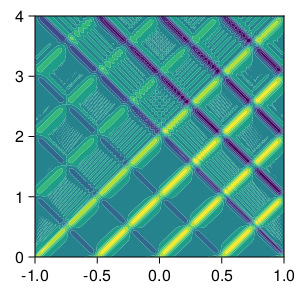

In [10]:
fig = Figure(resolution = (300, 300))
ax = Axis(fig[1,1])
contourf!(fig[1,1], vec(x), vec(t), vec(u))
fig

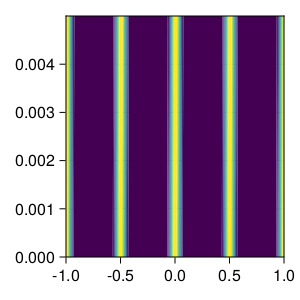

In [11]:
fig = Figure(resolution = (300, 300))
ax = Axis(fig[1, 1])
contourf!(vec(x[:,1:2]), vec(t[:,1:2]), vec(u[:,1:2]))
fig

# Problem 2

What is the stability limit? Why does this happen? How could you avoid this limit?

Answer: Since I wrote the step size in my coordinate function in terms of the number of steps input, I am simply tuning the number of steps in the $x$ and $t$ to ge tthe desired step size.

In [12]:
ntime = 500
nx = 500
starttime = 0
endtime = 4
startspatial = -L
endspatial = L

t, x = coords(starttime, endtime, startspatial, endspatial, ntime, nx);
u = standing(t, x);
evolve!(u, dt, dx)

dt = 0.008
 dx = 0.004

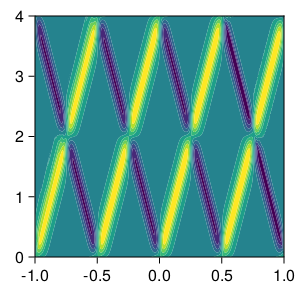

In [13]:
fig = Figure(resolution = (300, 300))
ax = Axis(fig[1,1])
contourf!(fig[1,1], vec(x), vec(t), vec(u))
fig

In [14]:
# Calculate error
function calculate_error(t, x, u)
    ni, nn = size(u)
    err = similar(u)
    for n in 1:nn, i in 1:ni
        err[i,n] = u[i,n] - A * exp(-1/2 * sin(2*pi/L* (x[i, n]-t[i, n]))^2 / W^2)
    end
    return err
end

calculate_error (generic function with 1 method)

In [15]:
err = calculate_error(t, x, u)
maximum(abs.(err))

5.229947947402069

In [16]:
size(vec(x))

(251001,)

In [17]:
size(vec(t))

(251001,)

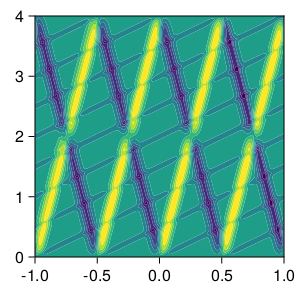

In [18]:
# Show error
fig = Figure(resolution = (300, 300))
ax = Axis(fig[1, 1])
contourf!(vec(x), vec(t), vec(err))
fig

# Problem 3

In [19]:
nx = 100
ntime =100
t, x = coords(starttime, endtime, startspatial, endspatial, ntime, nx);
u = standing(t, x);

dt = 0.04
 dx = 0.02

In [20]:
#dx = (endspatial - startspatial)/nx
#dt = (endtime-starttime)/ntime
#ux = zeros(nx)
#ut = zeros(ntime)
#for i in 2:nx
 #   ux[i] = (u[i+1, 1]-u[i-1,1])/2dx;
#end

#for i in 2:ntime
#    ut[i] = (u[1, i+1]-u[1,i-1])/2dt;
#end
#ux = (u[i-1,n-1] - 2*u[i,n-1] + u[i+1,n-1]) / dx

In [21]:
#eps = 1/2 * ((ut.^2)+ (ux).^2)
function epsFunc(starttime, endtime, startspatial, endspatial, ntime, nx)
    dx = (endspatial - startspatial)/nx
    dt = (endtime-starttime)/ntime
    ux = zeros(nx)
    ut = zeros(ntime)
    for i in 2:nx
        ux[i] = (u[i+1, 1]-u[i-1,1])/2dx;
    end

    for i in 2:ntime
        ut[i] = (u[1, i+1]-u[1,i-1])/2dt;
    end
    epsi = zeros(nx, ntime)
    for i in 2:nx
        for j in 2:ntime
            epsi[i, j] = 1/2 * ((ut[j].^2)+ (ux[i]).^2)
        end
    end
        
    return epsi
end

epsFunc (generic function with 1 method)

In [22]:
epsi = epsFunc(starttime, endtime, startspatial, endspatial, ntime, nx);

In [23]:
size(t)

(101, 101)

In [24]:
size(epsi)

(100, 100)

In [25]:
size(t[1:ntime, 1:ntime])

(100, 100)

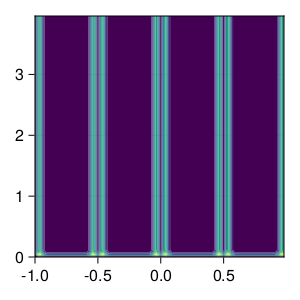

In [26]:
# Show error
fig = Figure(resolution = (300, 300))
ax = Axis(fig[1, 1])
contourf!(vec(x[1:nx, 1:nx]), vec(t[1:ntime, 1:ntime]), vec(epsi))
fig

How well is the energy conserved? How does this depend on the grid spacings dx and `dt?# Problem 4

How well is the energy conserved? How does this depend on the grid spacings dx and `dt?

In [27]:
# Integrate `epsilon` over space
function integrate(epsilon, n, dx)
    ni, nt = size(epsilon)
    # The boundary points are special; they have a weight of 1/2.
    # There are `ni` points overall, and the grid spacing is `dx = 2L/(ni-1)`.
    # Integrating the constant function `epsilon=1` thus gives exactly `2L`.
    E = epsilon[1, n ] / 2
    for i in 2:ni-1
        E += epsilon[i, n]
    end
    E += epsilon[ni, n] / 2
    # Scale by the grid spacing
    E *= dx
    return E
end

integrate (generic function with 1 method)

In [28]:
minimum(epsi)

0.0

In [29]:
Evec = zeros(size(epsi)[2])
for j in 1:size(epsi)[2]
        Evec[j] = integrate(epsi, j, dx)
end
size(Evec)

(100,)

In [30]:
#print(Evec)

In [40]:
size(Evec)

(100,)

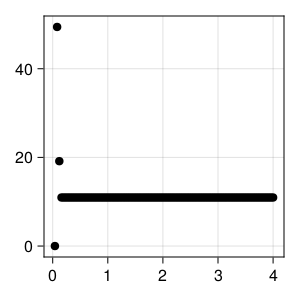

In [44]:
fig = Figure(resolution = (300, 300))
ax = Axis(fig[1, 1])
plot!(vec(t[1, 2:101]), Evec)
fig

We can see from this plot that the energy has some variation in the beginning due to boundary effects, but is roughly constant for the rest of the time which is what we expect due to conservation of energy.

In [45]:
# Show error
#fig = Figure(resolution = (300, 300))
#ax = Axis(fig[1, 1])
#contourf!(vec(x[1:nx, 1:nx]), vec(t[1:ntime, 1:ntime]), vec(Evec))
#fig

In [34]:
size(x[1:nx, 1:nx])

(100, 100)

# Notes

In [35]:
?LinRange

search: LinRange



```
LinRange{T,L}
```

A range with `len` linearly spaced elements between its `start` and `stop`. The size of the spacing is controlled by `len`, which must be an `Integer`.

# Examples

```jldoctest
julia> LinRange(1.5, 5.5, 9)
9-element LinRange{Float64, Int64}:
 1.5,2.0,2.5,3.0,3.5,4.0,4.5,5.0,5.5
```

Compared to using [`range`](@ref), directly constructing a `LinRange` should have less overhead but won't try to correct for floating point errors:

```jldoctest
julia> collect(range(-0.1, 0.3, length=5))
5-element Vector{Float64}:
 -0.1
  0.0
  0.1
  0.2
  0.3

julia> collect(LinRange(-0.1, 0.3, 5))
5-element Vector{Float64}:
 -0.1
 -1.3877787807814457e-17
  0.09999999999999999
  0.19999999999999998
  0.3
```
